In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf


from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPU


In [3]:
# download dummy dataset for testing
! wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2022-01-26 20:22:14--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: 'lfw.tgz.8'

     0K .......... .......... .......... .......... ..........  0%  933K 3m9s
    50K .......... .......... .......... .......... ..........  0% 1,76M 2m23s
   100K .......... .......... .......... .......... ..........  0% 9,59M 1m42s
   150K .......... .......... .......... .......... ..........  0% 10,4M 80s
   200K .......... .......... .......... .......... ..........  0% 2,73M 77s
   250K .......... .......... .......... .......... ..........  0% 7,89M 68s
   300K .......... .......... .......... .......... ..........  0% 2,78M 67s
   350K .......... .......... .......... .......... ..........  0% 6,20M 62s
   400K .......... .......... ....

In [4]:
# extract dataset
! tar -xvzf lfw.tgz


 20000K .......... .......... .......... .......... .......... 11% 6,64M 17s
 20050K .......... .......... .......... .......... .......... 11% 10,9M 17s
 20100K .......... .......... .......... .......... .......... 11% 12,5M 17s
 20150K .......... .......... .......... .......... .......... 11% 10,0M 17s
 20200K .......... .......... .......... .......... .......... 11% 12,5M 17s
 20250K .......... .......... .......... .......... .......... 11% 7,36M 17s
 20300K .......... .......... .......... .......... .......... 11% 10,2M 17s
 20350K .......... .......... .......... .......... .......... 11% 25,7M 17s
 20400K .......... .......... .......... .......... .......... 11% 9,37M 17s
 20450K .......... .......... .......... .......... .......... 11% 12,8M 17s
 20500K .......... .......... .......... .......... .......... 11% 9,75M 17s
 20550K .......... .......... .......... .......... .......... 11% 8,11M 17s
 20600K .......... .......... .......... .......... .......... 11% 11,8M 17

In [5]:
#capture paths to images
all_images = glob.glob('lfw/**/*.jpg')

x lfw/Edmund_Stoiber/Edmund_Stoiber_0009.jpg
x lfw/Edmund_Stoiber/Edmund_Stoiber_0010.jpg
x lfw/Edmund_Stoiber/Edmund_Stoiber_0011.jpg
x lfw/Edmund_Stoiber/Edmund_Stoiber_0012.jpg
x lfw/Edmund_Stoiber/Edmund_Stoiber_0013.jpg
x lfw/Bob_Beauprez/
x lfw/Bob_Beauprez/Bob_Beauprez_0001.jpg
x lfw/Bob_Beauprez/Bob_Beauprez_0002.jpg
x lfw/George_W_Bush/
x lfw/George_W_Bush/George_W_Bush_0001.jpg
x lfw/George_W_Bush/George_W_Bush_0002.jpg
x lfw/George_W_Bush/George_W_Bush_0003.jpg
x lfw/George_W_Bush/George_W_Bush_0004.jpg
x lfw/George_W_Bush/George_W_Bush_0005.jpg
x lfw/George_W_Bush/George_W_Bush_0006.jpg
x lfw/George_W_Bush/George_W_Bush_0007.jpg
x lfw/George_W_Bush/George_W_Bush_0008.jpg
x lfw/George_W_Bush/George_W_Bush_0009.jpg
x lfw/George_W_Bush/George_W_Bush_0010.jpg
x lfw/George_W_Bush/George_W_Bush_0011.jpg
x lfw/George_W_Bush/George_W_Bush_0012.jpg
x lfw/George_W_Bush/George_W_Bush_0013.jpg
x lfw/George_W_Bush/George_W_Bush_0014.jpg
x lfw/George_W_Bush/George_W_Bush_0015.jpg
x lfw/G

In [6]:
# TODO: add validation for image size
#dummy dataset images are 250p X 250p 
high_quality_images = []
for i in tqdm(all_images):
  #can add target_size = (X, Y, 3) if it take too much computing power
  img = image.load_img(i, target_size = (80, 80, 3))
  img = image.img_to_array(img)
  img = img/255.
  high_quality_images.append(img)

100%|██████████| 13233/13233 [00:40<00:00, 330.74it/s]


In [31]:
high_quality_images = np.array(high_quality_images)

# split data into train and validation data
train_x, val_x = train_test_split(high_quality_images, random_state=32, test_size=0.1)

In [33]:
# blurr image to simulate low_resolution image
# wont be needed with good dataset, will be replaced by UE base image
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
  width = int(image.shape[1] * scale_percent / 100)
  height = int(image.shape[0] * scale_percent / 100)
  dim = (width, height)

  small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
  # scale back to original size
  width = int(small_image.shape[1] * 100 / scale_percent)
  height = int(small_image.shape[0] * 100 / scale_percent)
  dim = (width, height)

  low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

  return low_res_image


**Prepare Input Images**
lower resolutions of all the images
Must be removed once computing power won't be a problem

In [34]:
# get low resolution images for the training set
train_x_px = []
for i in range(train_x.shape[0]):
  temp = pixalate_image(train_x[i,:,:,:])
  train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
  temp = pixalate_image(val_x[i,:,:,:])
  val_x_px.append(temp)

val_x_px = np.array(val_x_px)



In [36]:
#Build model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout

with tf.device('/cpu:0'):
    Input_img = Input(shape=(80, 80, 3))  
    
    #encoding architecture
    x1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(Input_img)
    x2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x1)
    x3 = MaxPool2D(padding='same')(x2)
    x4 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x3)
    x5 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x4)
    x6 = MaxPool2D(padding='same')(x5)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x6)
    x6_7 = MaxPool2D(padding='same')(encoded)
    #encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    # # decoding architecture
    x7 = UpSampling2D()(encoded)
    x7 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
    x7 = UpSampling2D()(encoded)
    x8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x7)
    x9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x8)
    x10 = Add()([x5, x9])
    x11 = UpSampling2D()(x10)
    x12 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x11)
    x13 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l1(10e-10))(x12)
    x14 = Add()([x2, x13])
    # x3 = UpSampling2D((2, 2))(x3)
    # x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    # x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same',activation='relu', kernel_regularizer=regularizers.l1(10e-10))(x14)
    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    autoencoder.summary()
    



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 80, 80, 32)   896         ['input_5[0][0]']                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 80, 80, 32)   9248        ['conv2d_42[0][0]']              
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 40, 40, 32)  0           ['conv2d_43[0][0]']              
 )                                                                                          

In [37]:
#Train model
with tf.device('/cpu:0'):
  early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')
with tf.device('/device:GPU:0'):
  

  a_e = autoencoder.fit(train_x_px, train_x,
              epochs=50,
              batch_size=256,
              shuffle=True,
              validation_data=(val_x_px, val_x),
              callbacks=[early_stopper])

Epoch 1/50


ResourceExhaustedError: 2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[256,64,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_4/conv2d_50/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[Adam/IdentityN/_124]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[256,64,80,80] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_4/conv2d_50/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_49900]

Function call stack:
train_function -> train_function


In [25]:
from tensorflow.keras.models import Sequential, save_model, load_model
filepath = './saved_model_Y'
save_model(autoencoder, filepath)

INFO:tensorflow:Assets written to: ./saved_model_Y\assets


In [26]:
autoEncoderModel = load_model(filepath, compile = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


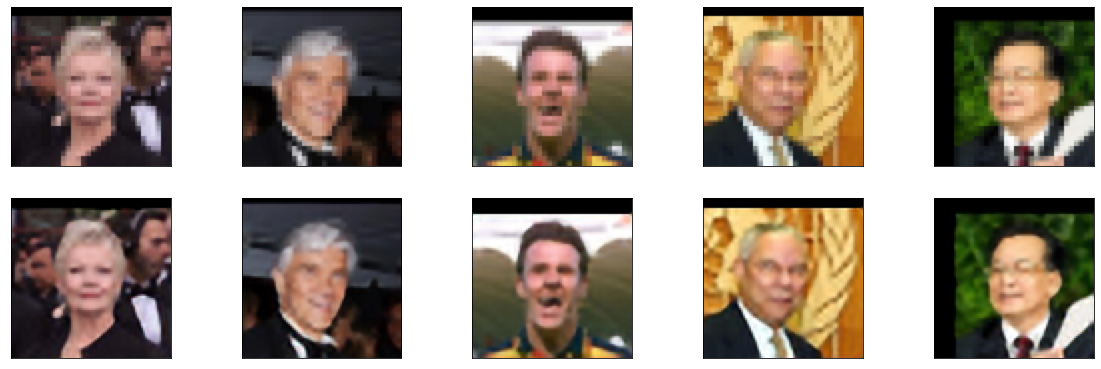

42/42 [==============================] - 1s 11ms/step - loss: 0.0027 - accuracy: 0.9024
val_loss, val_accuracy [0.002668937435373664, 0.9024067521095276]


In [27]:
predictions = autoEncoderModel.predict(val_x_px)
n = 5
plt.figure(figsize= (20,10))
for i in range(n):
  ax = plt.subplot(3, n, i+1)
  plt.imshow(val_x_px[i+5])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)  
  ax = plt.subplot(3, n, i+1+n)
  plt.imshow(predictions[i+5])
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

results = autoencoder.evaluate(val_x_px, val_x)
print('val_loss, val_accuracy', results)